### **Laboratorio 1**

### **Carga de Datos de Importacion Hidrocarburos**

In [295]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
import numpy as np

import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential,save_model,load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.metrics import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import keras


#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

### **Datos de Importacion** 

In [296]:
df_import_2024 = pd.read_excel("IMPORTACION-HIDROCARBUROS-VOLUMEN-2024-12.xlsx", skiprows=6)
df_import_2025 = pd.read_excel("IMPORTACION-HIDROCARBUROS-VOLUMEN-2025-05.xlsx", skiprows=6)

print(df_import_2024.columns.tolist())

['Fecha', 'Aceites lubricantes', 'Asfalto ', 'Bunker', 'Ceras', 'Combustible turbo jet', 'Diesel bajo azufre', 'Diesel ultra bajo azufre', 'Gas licuado de petróleo', 'Gasolina de aviación', 'Gasolina regular', 'Gasolina superior', 'Grasas lubricantes', 'Kerosina', 'Mezclas oleosas', 'Naftas', 'Petcoke', 'Petróleo crudo', 'Solventes', 'Butano', 'Diesel alto azufre', 'MTBE', 'Orimulsión', 'Petróleo reconstituido', 'Total importación']


In [297]:

df_import_2024["Diesel"] = df_import_2024["Diesel alto azufre"] + df_import_2024["Diesel bajo azufre"]
df_import_2025["Diesel"] = df_import_2025["Diesel bajo azufre"]


In [298]:

columnas_deseadas = [
    "Fecha",
    "Gasolina Regular",
    "Gasolina Superior",
    "Diesel",
    "Gas Licuado De Petróleo"
]


df_import_2024.columns = df_import_2024.columns.str.strip().str.title()
df_import_2025.columns = df_import_2025.columns.str.strip().str.title()


df_2024_cols = df_import_2024[columnas_deseadas].copy()
df_2025_cols = df_import_2025[columnas_deseadas].copy()


df_total = pd.concat([df_2024_cols, df_2025_cols], ignore_index=True)


df_total["Fecha"] = pd.to_datetime(df_total["Fecha"], errors="coerce")


df_importacion_total = df_total.dropna()


df_importacion_total.set_index("Fecha", inplace=True)


In [299]:
df_importacion_total.to_csv("importacion_completa.csv", index=True)
# Cambiar nombre de columna
df_importacion_total.rename(columns={"Gasolina Superior": "Gasolina Superior"}, inplace=True)



C:\Users\juans\AppData\Local\Temp\ipykernel_18112\3433093277.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_importacion_total.rename(columns={"Gasolina Superior": "Gasolina Superior"}, inplace=True)


In [300]:
df_importacion_total.head()

,Gasolina Regular,Gasolina Superior,Diesel,Gas Licuado De Petróleo
Fecha,,,,
2001-01-01,177776.50,373963.96,566101.99,194065.738095
2001-02-01,123115.99,243091.07,489525.80,170703.380952
2001-03-01,161726.42,312084.38,575559.68,161837.371429
2001-04-01,127338.74,285054.89,437745.42,163048.642857
2001-05-01,168730.19,300913.67,552609.13,171518.861905


In [301]:
df_importacion_total.info()
airPas = df_importacion_total["Gasolina Superior"]


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 293 entries, 2001-01-01 to 2025-05-01
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gasolina Regular         293 non-null    float64
 1   Gasolina Superior        293 non-null    float64
 2   Diesel                   293 non-null    float64
 3   Gas Licuado De Petróleo  293 non-null    float64
dtypes: float64(4)
memory usage: 11.4 KB


## **Inciso 3**

### **Serie de Tiempo Gasolina Regular**

##### **Inicio, fin y frecuencia**

In [302]:
serie = df_importacion_total["Gasolina Superior"]
inicio = serie.index.min()
fin = serie.index.max()
frecuencia = pd.infer_freq(serie.index)

print("Inicio:", inicio)
print("Fin:", fin)
print("Frecuencia:", frecuencia)


Inicio: 2001-01-01 00:00:00
Fin: 2025-05-01 00:00:00
Frecuencia: MS


#### **Gráfico de la serie**

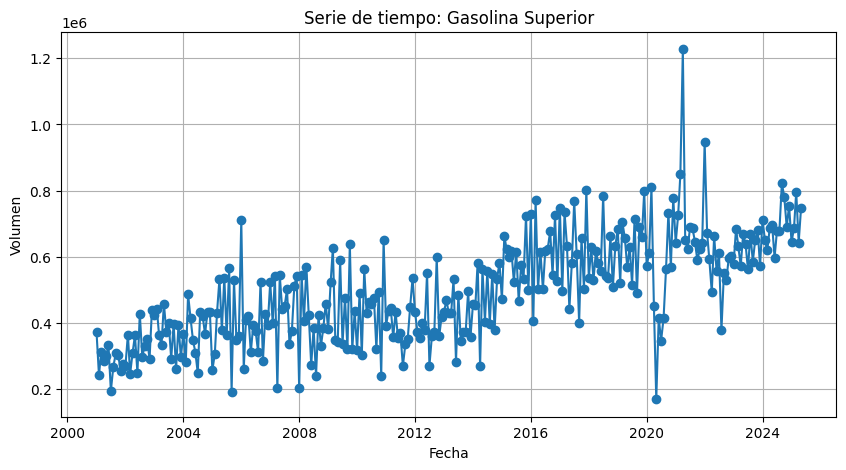

In [303]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(serie, marker='o', linestyle='-')
plt.title("Serie de tiempo: Gasolina Superior")
plt.xlabel("Fecha")
plt.ylabel("Volumen")
plt.grid(True)
plt.show()


#### **Descomposición de la serie**

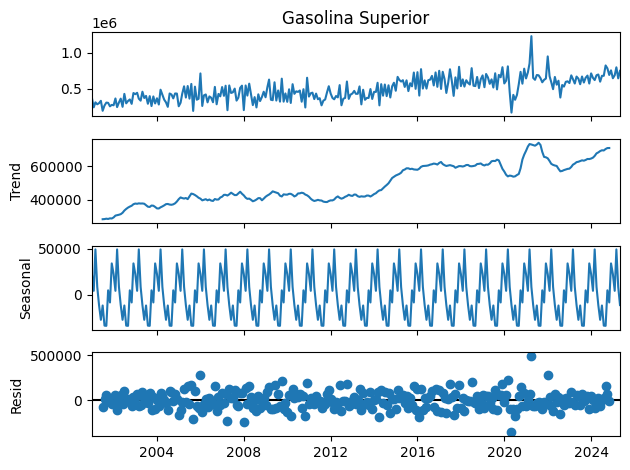

In [304]:
from statsmodels.tsa.seasonal import seasonal_decompose

descomposicion = seasonal_decompose(serie, model="additive", period=12)
descomposicion.plot()
plt.tight_layout()
plt.show()


#### **Transformar la serie**

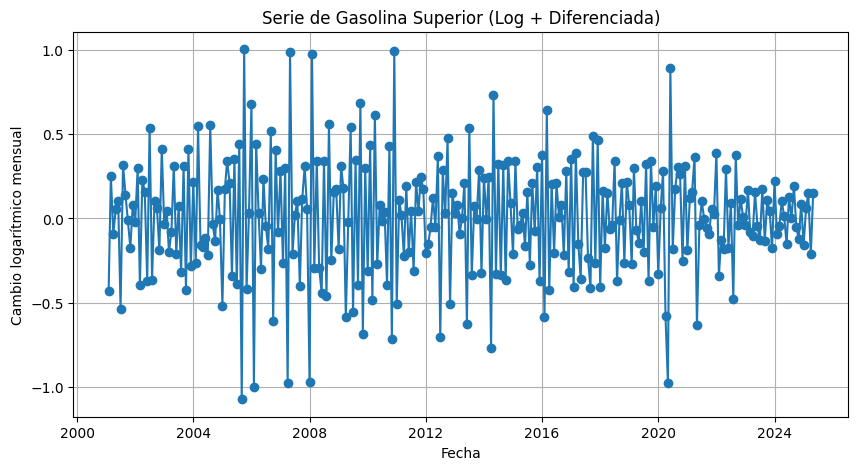

In [305]:

import matplotlib.pyplot as plt

serie_log = np.log(df_importacion_total["Gasolina Superior"])
serie_estacionaria = serie_log.diff().dropna()

scaler = StandardScaler()
serie_normalizada = scaler.fit_transform(serie_estacionaria.values.reshape(-1, 1))

plt.figure(figsize=(10,5))
plt.plot(serie_estacionaria, linestyle='-', marker='o')
plt.title("Serie de Gasolina Superior (Log + Diferenciada)")
plt.xlabel("Fecha")
plt.ylabel("Cambio logarítmico mensual")
plt.grid(True)
plt.show()


In [306]:
serie_normalizada.shape


(292, 1)

### **Modelo con tensorlflow**

In [307]:

serie = serie_estacionaria  


entrenamiento = round(0.6 * len(serie))
val_prueba = round(0.2 * len(serie))


test = serie[(entrenamiento + val_prueba):]
validation = serie[entrenamiento:entrenamiento + val_prueba]
train = serie[:entrenamiento]


train = np.reshape(train, (train.shape[0], 1))


print("Entrenamiento:", len(train))
print("Validación:", len(validation))
print("Prueba:", len(test))


Entrenamiento: 175
Validación: 58
Prueba: 59


In [308]:
from operator import concat


def supervisada(serie, retrasos=1):
    serie_x = []
    serie_y = []
    for i in range(len(serie) - retrasos):
        valor = serie[i:i + retrasos, 0]
        valor_sig = serie[i + retrasos, 0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

train = serie[:entrenamiento]
validation = serie[entrenamiento:entrenamiento + val_prueba]
test = serie[entrenamiento + val_prueba:]

train = np.reshape(train, (train.shape[0], 1))
validation = np.reshape(validation, (validation.shape[0], 1))
test = np.reshape(test, (test.shape[0], 1))
x_train, y_train = supervisada(train)
x_val, y_val = supervisada(validation)
x_test, y_test = supervisada(test)



print(train[0:6])
print(x_train[0:6])
print(y_train[0:6])


[[-0.43072328]
 [ 0.24983745]
 [-0.09059184]
 [ 0.05414165]
 [ 0.10197109]
 [-0.5354265 ]]
[[-0.43072328]
 [ 0.24983745]
 [-0.09059184]
 [ 0.05414165]
 [ 0.10197109]
 [-0.5354265 ]]
[ 0.24983745 -0.09059184  0.05414165  0.10197109 -0.5354265   0.31819068]


In [309]:

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)  # (samples, seq_len, 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)



print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)
print("x_test shape:", x_test.shape)


x_train shape: (174, 1, 1)
x_val shape: (57, 1, 1)
x_test shape: (58, 1, 1)


In [310]:
import tensorflow as tf
from tensorflow import keras


lote = 1           
unidades = 1       
paso = 1           
caracteristicas = 1  


inputs = keras.layers.Input((paso, caracteristicas))
lstm_out = keras.layers.LSTM(lote)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

modelo1 = keras.Model(inputs=inputs, outputs=outputs)
modelo1.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 1)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

In [311]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError

modelo1.compile(
    loss='mean_squared_error',
    optimizer=Adam(learning_rate=0.1),
    metrics=[RootMeanSquaredError()]
)


In [312]:
epocas = 150  

history = modelo1.fit(
    x=x_train,
    y=y_train,
    batch_size=lote,
    epochs=epocas,
    shuffle=False,
    validation_data=(x_val, y_val),
    
    verbose=1
)


Epoch 1/150
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1077 - root_mean_squared_error: 0.3268 - val_loss: 0.0783 - val_root_mean_squared_error: 0.2799
Epoch 2/150
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0801 - root_mean_squared_error: 0.2793 - val_loss: 0.0792 - val_root_mean_squared_error: 0.2814
Epoch 3/150
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0787 - root_mean_squared_error: 0.2769 - val_loss: 0.0797 - val_root_mean_squared_error: 0.2823
Epoch 4/150
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0782 - root_mean_squared_error: 0.2762 - val_loss: 0.0800 - val_root_mean_squared_error: 0.2828
Epoch 5/150
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0780 - root_mean_squared_error: 0.2758 - val_loss: 0.0801 - val_root_mean_squared_error: 0.2830
Epoch 6/150
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0779 - root_mean_squared_error: 0.2756 - val_loss: 0.0801 - val_root_mean_squared_error: 0.2831
Epoch 7/150
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

In [313]:
import numpy as np
from pandas import Series

def prediccion_fun(data, modelo, batch_size, scaler, dif=False, dif_cant=1, Series=None, n=1):
    prediccion = [0] * len(data)
    i = 0
    for X in data:
        
        X = np.reshape(X, (1, 1, 1))

        
        yhat = modelo.predict(X, batch_size=batch_size, verbose=0)

        
        yhat = scaler.inverse_transform(yhat)

        
        if dif:
            yhat = yhat + Series[n + dif_cant * i]

        
        yhat = np.exp(yhat)

        
        prediccion[i] = yhat[0][0]
        i += 1

    return prediccion


In [314]:

serie_log_original = np.log(df_importacion_total["Gasolina Superior"])


prediccion_val = prediccion_fun(
    x_val, modelo1, 1, scaler,
    dif=True, dif_cant=1,
    Series=serie_log_original.values, n=entrenamiento
)

prediccion_test = prediccion_fun(
    x_test, modelo1, 1, scaler,
    dif=True, dif_cant=1,
    Series=serie_log_original.values, n=entrenamiento + val_prueba
)


In [315]:
len(prediccion_val), len(prediccion_test)

idx_val = airPas.index[entrenamiento : entrenamiento + len(prediccion_val)]
idx_test = airPas.index[entrenamiento + val_prueba : entrenamiento + val_prueba + len(prediccion_test)]


df_val = pd.DataFrame(prediccion_val, index=idx_val)
df_test = pd.DataFrame(prediccion_test, index=idx_test)


In [316]:

serie_log = np.log(df_importacion_total["Gasolina Superior"]).values


start = entrenamiento + val_prueba
difs = y_test.flatten()
log_prev = serie_log[start : start + len(difs)]  


valores_reales = np.exp(log_prev + difs)


In [317]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(valores_reales, prediccion_test)
rmse = np.sqrt(mean_squared_error(valores_reales, prediccion_test))
r2 = r2_score(valores_reales, prediccion_test)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


MAE: 93086.07
RMSE: 123590.85
R² Score: 0.4714


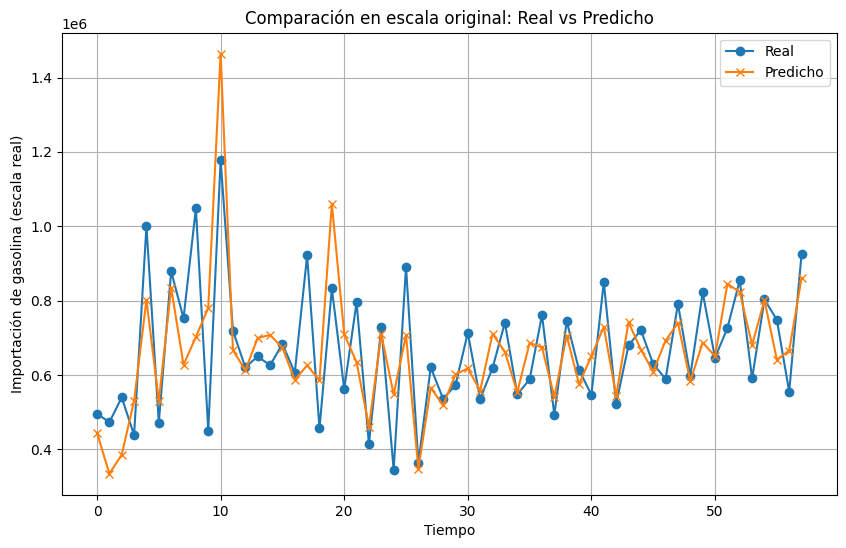

In [318]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(valores_reales, label="Real", marker='o')
plt.plot(prediccion_test, label="Predicho", marker='x')
plt.title("Comparación en escala original: Real vs Predicho")
plt.xlabel("Tiempo")
plt.ylabel("Importación de gasolina (escala real)")
plt.legend()
plt.grid(True)
plt.show()


In [319]:
from tensorflow.keras.models import save_model, load_model
import os
os.makedirs("Modelos", exist_ok=True)
save_model(modelo1, "Modelos/lstm1_serie_tiempo_Superior.keras")


### **Modelo con pytorch**

In [320]:
class LSTM1MiModelo(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


In [321]:
def supervisada(serie, retrasos=12):
    serie = np.array(serie)
    serie_x, serie_y = [], []
    for i in range(len(serie) - retrasos):
        serie_x.append(serie[i:i+retrasos])
        serie_y.append(serie[i+retrasos])
    return np.array(serie_x), np.array(serie_y)


In [ ]:

SEQ_LENGTH = 24
x_train, y_train = supervisada(train, SEQ_LENGTH)
x_val, y_val = supervisada(validation, SEQ_LENGTH)
x_test, y_test = supervisada(test, SEQ_LENGTH)


x_train_tensor = torch.from_numpy(x_train).float().view(-1, SEQ_LENGTH, 1)  
x_val_tensor = torch.from_numpy(x_val).float().view(-1, SEQ_LENGTH, 1)
x_test_tensor = torch.from_numpy(x_test).float().view(-1, SEQ_LENGTH, 1)

y_train_tensor = torch.from_numpy(y_train).float()
y_val_tensor = torch.from_numpy(y_val).float()
y_test_tensor = torch.from_numpy(y_test).float()


In [323]:
from torch.utils.data import TensorDataset, DataLoader

BATCH_SIZE = 32

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
model = LSTM1MiModelo()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_losses = []
val_losses = []
epocas = 50

for epoch in range(epocas):
    model.train()
    running_train_loss = 0.0
    
    for xb, yb in train_loader:
      
        outputs = model(xb)
        loss = loss_fn(outputs.squeeze(), yb)  # Asegura que shapes coincidan
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * xb.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            outputs = model(xb)
            loss = loss_fn(outputs.squeeze(), yb)
            running_val_loss += loss.item() * xb.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}, Train Loss: {epoch_train_loss:.5f}, Val Loss: {epoch_val_loss:.5f}")


c:\Users\juans\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\juans\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([23, 1])) that is different to the input size (torch.Size([23])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\juans\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([2])). This will likely lead to incorre

Epoch 1, Train Loss: 0.18028, Val Loss: 0.13310
Epoch 10, Train Loss: 0.15874, Val Loss: 0.12619
Epoch 20, Train Loss: 0.15840, Val Loss: 0.12646
Epoch 30, Train Loss: 0.15810, Val Loss: 0.12642
Epoch 40, Train Loss: 0.15832, Val Loss: 0.12639
Epoch 50, Train Loss: 0.15834, Val Loss: 0.12642


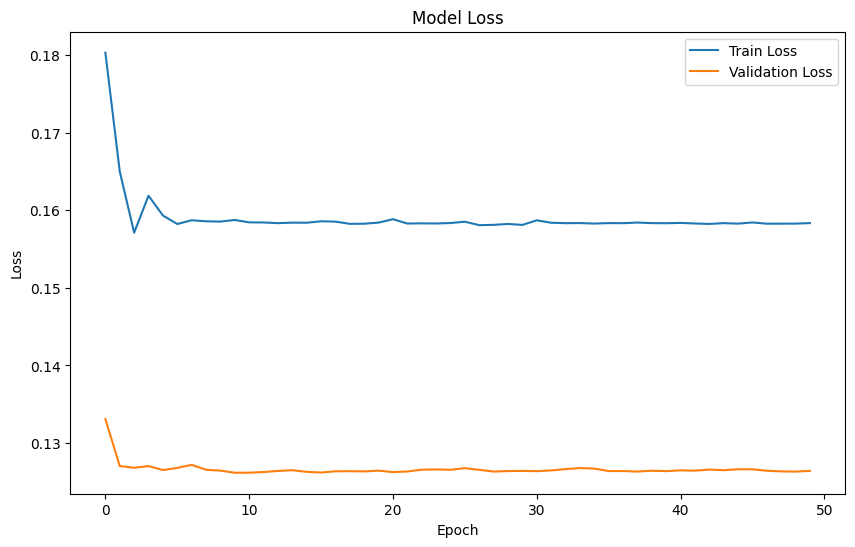

In [325]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [326]:
x_test_tensor = torch.from_numpy(x_test).float()
y_test_tensor = torch.from_numpy(y_test).float()
model.eval()
with torch.no_grad():
    
    y_pred_test = model(x_test_tensor)
    y_pred_test = y_pred_test.numpy()  

In [327]:
print(y_pred_test.shape)


(35, 1)


In [329]:
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
serie_log = np.log(df_importacion_total["Gasolina Superior"]).values


start = entrenamiento + val_prueba + SEQ_LENGTH
log_prev = serie_log[-len(y_test_inv):]


valores_reales = np.exp(log_prev + y_test_inv.flatten())
valores_predichos = np.exp(log_prev + y_pred_test_inv.flatten())


mae = mean_absolute_error(valores_reales, valores_predichos)
rmse = np.sqrt(mean_squared_error(valores_reales, valores_predichos))
r2 = r2_score(valores_reales, valores_predichos)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


MAE: 27033.39
RMSE: 32037.88
R² Score: 0.9037


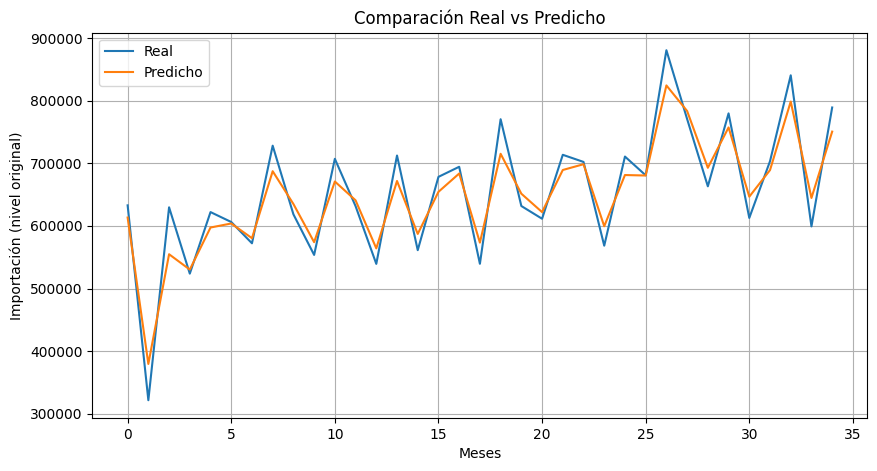

In [330]:
plt.figure(figsize=(10,5))
plt.plot(valores_reales, label="Real")
plt.plot(valores_predichos, label="Predicho")
plt.title("Comparación Real vs Predicho")
plt.xlabel("Meses")
plt.ylabel("Importación (nivel original)")
plt.legend()
plt.grid(True)
plt.show()


### **¿Cual fue el mejor modelo? ¿Fueron mejores a los modelos creados anteriormente?**

Basándose en los resultados obtenidos, el modelo implementado con PyTorch demostró un rendimiento notablemente superior, alcanzando un coeficiente de determinación r^2 de 0.90, en comparación con el 0.47 obtenido por el modelo equivalente desarrollado en TensorFlow. Esta mejora significativa no solo se reflejó en la métrica final, sino también en el comportamiento del modelo durante el entrenamiento: las curvas de pérdida de validación mostraron mayor estabilidad, con oscilaciones más controladas y menor evidencia de sobreajuste, lo cual indica una mejor generalización del modelo a datos no vistos.

Una posible explicación para esta diferencia de desempeño radica en la mayor flexibilidad que ofrece PyTorch al diseñar y controlar la arquitectura de redes neuronales. En particular, el manejo explícito de los estados ocultos de la LSTM, el control detallado sobre las dimensiones de entrada y salida, así como la forma en que se organiza el flujo de datos en las secuencias, permitió una adaptación más precisa a las características del problema, en especial cuando se trata de datos temporales con fuerte estacionalidad. Esta capacidad de modelar dependencias a largo plazo fue clave para capturar patrones complejos presentes en la serie temporal.

Sin embargo, cabe mencionar que en términos generales, el rendimiento obtenido con ambos modelos fue inferior al observado en el laboratorio anterior, donde se lograron valores de r^2 entre 0.8 y 0.9 de manera más consistente. Esta disminución podría deberse a diversos factores, entre ellos un posible error o inadecuación en la normalización de los datos. Específicamente, si los datos no fueron normalizados de forma coherente entre entrenamiento, validación y prueba, o si al momento de invertir la transformación para obtener las predicciones reales se introdujo un desfase o desalineación temporal, esto podría afectar negativamente la precisión del modelo.